In [1]:
# import pandas as pd

# # Read the CSV
# df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")

# # Print column names
# print(df.columns.tolist())
import pandas as pd

# Read the CSV
df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")

# Print column names
#print(df.columns.tolist())

df = df[
    (df['RPL_THEMES'] != -999) &
    (df['EPL_MUNIT'] != -999)
]

mapping = {'LIGHT': 0, 'MODERATE': 1, 'HEAVY': 2}
df['initial_attack_activity'] = df['initial_attack_activity'].map(mapping)



matched = df

import numpy as np
# Define variable sets
hazard_vars = [
    'vpd_Normal', 'bi_Normal', 'fm100_Normal',
    'srad_Normal', 'sph_Normal', 'Slope', 'TRI', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars + values_vars + capacity_vars

# # Define placeholder values and problematic columns
# placeholder_vals = [-999, -999.0, -3.402823e+38]
# problem_columns = ['SDI', 'GHM', 'RPL_THEMES', 'EPL_MUNIT']

# # Print length before cleaning
# print(f"Original matched length: {len(matched)}")

# # Replace known placeholder values with NaN
# for col in problem_columns:
#     matched[col] = matched[col].replace(placeholder_vals, np.nan)

print(len(matched))

# Drop rows where SDI or GHM are < 0
#matched = matched[(matched['SDI'] > 0) & (matched['GHM'] > 0)]

matched['SDI'] = matched['SDI'].where(matched['SDI'] >= 0, 0)
matched['GHM'] = matched['GHM'].where(matched['GHM'] >= 0, 0)

# Drop rows with missing predictor or target values
matched_clean = matched.dropna(subset=predictors + ['event_type'])

# Print length after cleaning
print(f"Cleaned matched_clean length: {len(matched_clean)}")

# Print unique event_type values and their counts
event_counts = matched_clean['event_type'].value_counts()
print("Event type counts:")
print(event_counts)

# Print number of unique event types
print(f"\nNumber of unique event types: {matched_clean['event_type'].nunique()}")



C:\Users\magst\AppData\Local\Temp\ipykernel_25328\3623525150.py:11: DtypeWarning: Columns (14,15,16,17,311) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")


455960
Cleaned matched_clean length: 445107
Event type counts:
event_type
0    435433
1      9674
Name: count, dtype: int64

Number of unique event types: 2


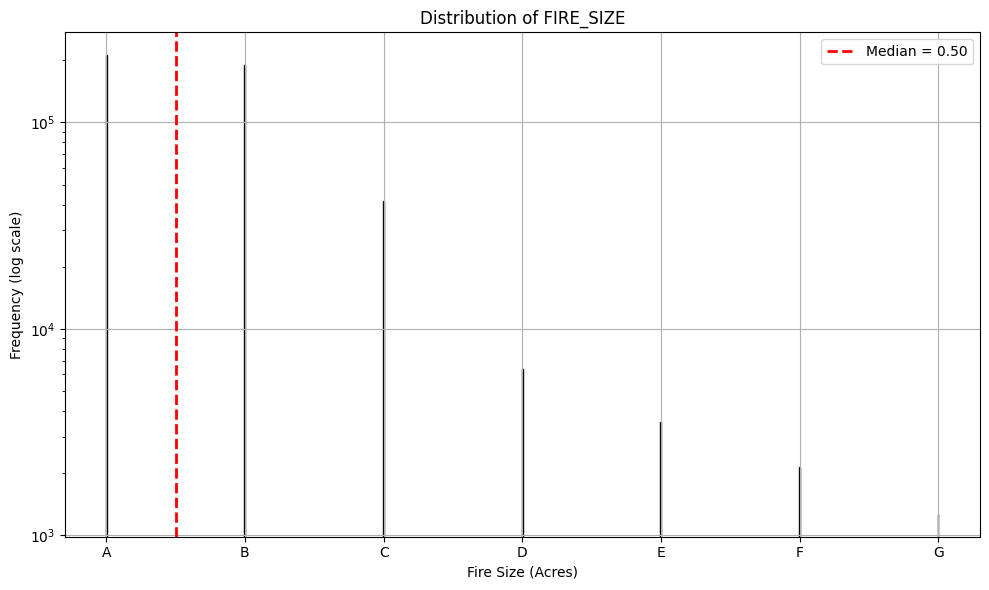

Median FIRE_SIZE (50/50 split): 0.5
Number of fires > 300 acres: 6725


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the median
median_fire_size = df['FIRE_SIZE'].median()

plt.figure(figsize=(10, 6))
plt.hist(df['FIRE_SIZE_CLASS'], bins=1000, edgecolor='black', log=True)
plt.axvline(x=median_fire_size, color='red', linestyle='--', linewidth=2, label=f'Median = {median_fire_size:.2f}')
plt.xlabel('Fire Size (Acres)')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of FIRE_SIZE')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print("Median FIRE_SIZE (50/50 split):", df['FIRE_SIZE'].median())
count_over_300 = (df['FIRE_SIZE'] > 300).sum()
print("Number of fires > 300 acres:", count_over_300)


In [3]:
count_over_300 = (df['FIRE_SIZE'] > 100).sum()
print("Number of fires > 300 acres:", count_over_300)

Number of fires > 300 acres: 12547


In [4]:
print("Total FIRE_SIZE entries (including NaNs):", len(df['FIRE_SIZE']))
print("Number of FIRE_SIZE values:", df['FIRE_SIZE'].count())



Total FIRE_SIZE entries (including NaNs): 455960
Number of FIRE_SIZE values: 455960


In [ ]:
# MODEL RUNS RAN 7_15_2025

In [5]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars + values_vars + capacity_vars


C:\Users\magst\AppData\Local\Temp\ipykernel_25328\1494853807.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


In [6]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_FULL.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold



C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.797 | F1: 0.148
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.808 | F1: 0.162
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.792 | F1: 0.148
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.791 | F1: 0.143
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.797 | F1: 0.148
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.795 | F1: 0.143
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.789 | F1: 0.144
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.795 | F1: 0.145
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.798 | F1: 0.155
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.804 | F1: 0.155

Logistic Regression (10‑fold CV)
  AUC        : 0.796 ± 0.006
  F1         : 0.149 ± 0.006
  Precision  : 0.103 ± 0.016
  Recall     : 0.304 ± 0.079
  Threshold  : 0.77

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.831 ± 0.008
  F1         : 0.182 ± 0.009
  Precision  : 0.132 ± 0.010
  Recall     : 0.300 ± 0.042
  Threshold  : 0.83

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.835 ± 0.005
  F1         : 0.190 ± 0.008
  Precision  : 0.139 ± 0.010
  Recall     : 0.309 ± 0.048
  Threshold  : 0.82

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_FULL.csv


In [7]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars + values_vars #+ capacity_vars


In [8]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_haz_val.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.794 | F1: 0.142
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.804 | F1: 0.160
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.789 | F1: 0.145
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.789 | F1: 0.140
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.794 | F1: 0.145
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.791 | F1: 0.140
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.788 | F1: 0.140
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.793 | F1: 0.144
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.794 | F1: 0.153
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.803 | F1: 0.150

Logistic Regression (10‑fold CV)
  AUC        : 0.794 ± 0.005
  F1         : 0.146 ± 0.006
  Precision  : 0.101 ± 0.014
  Recall     : 0.291 ± 0.066
  Threshold  : 0.77

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.831 ± 0.005
  F1         : 0.185 ± 0.006
  Precision  : 0.135 ± 0.010
  Recall     : 0.302 ± 0.043
  Threshold  : 0.83

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.839 ± 0.006
  F1         : 0.196 ± 0.010
  Precision  : 0.144 ± 0.009
  Recall     : 0.314 ± 0.039
  Threshold  : 0.85

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_haz_val.csv


In [9]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars + capacity_vars #+ values_vars


In [10]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_haz_cap.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.695 | F1: 0.099
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.691 | F1: 0.095
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.700 | F1: 0.099
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.683 | F1: 0.097
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.701 | F1: 0.104
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.694 | F1: 0.097
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.672 | F1: 0.091
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.686 | F1: 0.092
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.690 | F1: 0.090
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.698 | F1: 0.094

Logistic Regression (10‑fold CV)
  AUC        : 0.691 ± 0.008
  F1         : 0.096 ± 0.004
  Precision  : 0.060 ± 0.005
  Recall     : 0.246 ± 0.045
  Threshold  : 0.66

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.772 ± 0.006
  F1         : 0.142 ± 0.006
  Precision  : 0.101 ± 0.010
  Recall     : 0.251 ± 0.040
  Threshold  : 0.78

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.776 ± 0.007
  F1         : 0.141 ± 0.005
  Precision  : 0.101 ± 0.012
  Recall     : 0.254 ± 0.050
  Threshold  : 0.75

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_haz_cap.csv


In [11]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = values_vars + capacity_vars # hazard_vars + 


In [12]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_val_cap.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.762 | F1: 0.118
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.777 | F1: 0.133
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.765 | F1: 0.127
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.757 | F1: 0.122
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.768 | F1: 0.123
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.761 | F1: 0.115
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.766 | F1: 0.122
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.768 | F1: 0.114
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.769 | F1: 0.124
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.772 | F1: 0.134

Logistic Regression (10‑fold CV)
  AUC        : 0.767 ± 0.005
  F1         : 0.123 ± 0.006
  Precision  : 0.084 ± 0.009
  Recall     : 0.247 ± 0.058
  Threshold  : 0.75

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.773 ± 0.007
  F1         : 0.129 ± 0.007
  Precision  : 0.085 ± 0.009
  Recall     : 0.288 ± 0.064
  Threshold  : 0.75

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.774 ± 0.006
  F1         : 0.129 ± 0.005
  Precision  : 0.083 ± 0.005
  Recall     : 0.296 ± 0.042
  Threshold  : 0.74

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_val_cap.csv


In [13]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = values_vars# + capacity_vars # hazard_vars + 


In [14]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_val.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.757 | F1: 0.112
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.772 | F1: 0.125
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.761 | F1: 0.121
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.756 | F1: 0.111
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.763 | F1: 0.114
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.758 | F1: 0.116
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.764 | F1: 0.115
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.765 | F1: 0.107
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.763 | F1: 0.114
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.768 | F1: 0.122

Logistic Regression (10‑fold CV)
  AUC        : 0.763 ± 0.005
  F1         : 0.116 ± 0.005
  Precision  : 0.076 ± 0.008
  Recall     : 0.263 ± 0.085
  Threshold  : 0.74

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.773 ± 0.006
  F1         : 0.119 ± 0.005
  Precision  : 0.073 ± 0.007
  Recall     : 0.336 ± 0.047
  Threshold  : 0.74

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.772 ± 0.005
  F1         : 0.119 ± 0.004
  Precision  : 0.075 ± 0.006
  Recall     : 0.319 ± 0.084
  Threshold  : 0.75

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_val.csv


In [15]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = capacity_vars # hazard_vars +  values_vars +


In [16]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_cap.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.593 | F1: 0.066
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.582 | F1: 0.075
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.594 | F1: 0.071
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.565 | F1: 0.069
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.578 | F1: 0.076
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.575 | F1: 0.060
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.579 | F1: 0.070
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.579 | F1: 0.077
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.587 | F1: 0.079
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.585 | F1: 0.072

Logistic Regression (10‑fold CV)
  AUC        : 0.582 ± 0.008
  F1         : 0.071 ± 0.005
  Precision  : 0.051 ± 0.006
  Recall     : 0.122 ± 0.026
  Threshold  : 0.62

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.587 ± 0.013
  F1         : 0.066 ± 0.005
  Precision  : 0.042 ± 0.007
  Recall     : 0.173 ± 0.043
  Threshold  : 0.56

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.587 ± 0.012
  F1         : 0.065 ± 0.006
  Precision  : 0.039 ± 0.004
  Recall     : 0.196 ± 0.036
  Threshold  : 0.54

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_cap.csv


In [17]:
import numpy as np
# Define variable sets

matched_clean['sph_Normal_1000'] = matched_clean['sph_Normal'] * 1000


hazard_vars = [
    'vpd_Normal', 'bi_Normal',
    'srad_Normal', 'sph_Normal_1000', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars


In [18]:
# NEED TO RUN TONIGHT 7_15_2025

import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, os, shutil, tempfile, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# def build_model_2layer(hp):
#     units = hp.Int('units', 16, 256, 16)
#     lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
#     m = models.Sequential([
#         layers.Input(shape=(X_train_scaled.shape[1],)),
#         layers.Dense(units, activation='relu'),
#         layers.Dense(units, activation='relu'),  # <-- second hidden layer
#         layers.Dense(1, activation='sigmoid')
#     ])
#     m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
#               loss='binary_crossentropy',
#               metrics=[tf.keras.metrics.AUC(name='auc')])
#     return m

def build_model_2layer(hp, input_shape):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(units, activation='relu'),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m

def build_model(hp):
    units = hp.Int('units', 16, 256, 16)
    lr_rate = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    m = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    m.compile(optimizer=tf.keras.optimizers.Adam(lr_rate),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc')])
    return m


# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

nn_auc, nn_f1, nn_prec, nn_rec, nn_thr = [], [], [], [], []

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr = [], [], [], [], []
nn_auc2, nn_f12, nn_prec2, nn_rec2, nn_thr2 = [], [], [], [], []

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print("fold")
    # Split
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)

    best_t_lr, best_f_lr = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_lr > t)
        if f > best_f_lr:
            best_f_lr, best_t_lr = f, t
    pred_lr = proba_lr > best_t_lr

    lr_auc.append(auc_lr)
    lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr))
    lr_rec.append(recall_score(y_test_fold, pred_lr))
    lr_thr.append(best_t_lr)

    # ── Neural Network with inner tuning ──────────────────────────────────────
    tf.keras.backend.clear_session()
    classes = np.unique(y_train_fold)
    cw = dict(zip(classes, compute_class_weight(class_weight='balanced', classes=classes, y=y_train_fold)))

    tmp_dir = tempfile.mkdtemp()
    tuner = kt.RandomSearch(
        build_model,
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn = tuner.get_best_models(1)[0]
    proba_nn = best_nn.predict(X_test_scaled, verbose=0).flatten()
    auc_nn   = roc_auc_score(y_test_fold, proba_nn)

    best_t_nn, best_f_nn = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn > t)
        if f > best_f_nn:
            best_f_nn, best_t_nn = f, t
    pred_nn = proba_nn > best_t_nn

    nn_auc.append(auc_nn)
    nn_f1.append(best_f_nn)
    nn_prec.append(precision_score(y_test_fold, pred_nn))
    nn_rec.append(recall_score(y_test_fold, pred_nn))
    nn_thr.append(best_t_nn)


        
    # ── Neural Network 2 Layer with inner tuning ──────────────────────────────────────
    tmp_dir = tempfile.mkdtemp()
    # tuner = kt.RandomSearch(
    #     build_model_2layer,
    #     objective='val_auc',
    #     max_trials=5,
    #     directory=tmp_dir,
    #     project_name=f'nn2layer_fold_{fold}'
    # )
    tuner = kt.RandomSearch(
        lambda hp: build_model_2layer(hp, input_shape=(X_train_scaled.shape[1],)),
        objective='val_auc',
        max_trials=20,
        directory=tmp_dir,
        project_name=f'nn2layer_fold_{fold}'
    )
    tuner.search(X_train_scaled, y_train_fold,
                 epochs=30,
                 batch_size=512,
                 validation_split=0.2,
                 callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
                 class_weight=cw,
                 verbose=0)

    best_nn2 = tuner.get_best_models(1)[0]
    proba_nn2 = best_nn2.predict(X_test_scaled, verbose=0).flatten()
    auc_nn2   = roc_auc_score(y_test_fold, proba_nn2)

    best_t_nn2, best_f_nn2 = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test_fold, proba_nn2 > t)
        if f > best_f_nn2:
            best_f_nn2, best_t_nn2 = f, t
    pred_nn2 = proba_nn2 > best_t_nn2

    nn_auc2.append(auc_nn2)
    nn_f12.append(best_f_nn2)
    nn_prec2.append(precision_score(y_test_fold, pred_nn2))
    nn_rec2.append(recall_score(y_test_fold, pred_nn2))
    nn_thr2.append(best_t_nn2)

    print(f"Fold {fold} | AUC: {auc_lr:.3f} | F1: {best_f_lr:.3f}")
    
    shutil.rmtree(tmp_dir, ignore_errors=True)
    gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression (10‑fold CV)")
print(f"  AUC        : {np.mean(lr_auc):.3f} ± {np.std(lr_auc):.3f}")
print(f"  F1         : {np.mean(lr_f1):.3f} ± {np.std(lr_f1):.3f}")
print(f"  Precision  : {np.mean(lr_prec):.3f} ± {np.std(lr_prec):.3f}")
print(f"  Recall     : {np.mean(lr_rec):.3f} ± {np.std(lr_rec):.3f}")
print(f"  Threshold  : {np.mean(lr_thr):.2f}")

print("\nNeural Network (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc):.3f} ± {np.std(nn_auc):.3f}")
print(f"  F1         : {np.mean(nn_f1):.3f} ± {np.std(nn_f1):.3f}")
print(f"  Precision  : {np.mean(nn_prec):.3f} ± {np.std(nn_prec):.3f}")
print(f"  Recall     : {np.mean(nn_rec):.3f} ± {np.std(nn_rec):.3f}")
print(f"  Threshold  : {np.mean(nn_thr):.2f}")

print("\nNeural Network 2 layer (10‑fold CV w/ tuning)")
print(f"  AUC        : {np.mean(nn_auc2):.3f} ± {np.std(nn_auc2):.3f}")
print(f"  F1         : {np.mean(nn_f12):.3f} ± {np.std(nn_f12):.3f}")
print(f"  Precision  : {np.mean(nn_prec2):.3f} ± {np.std(nn_prec2):.3f}")
print(f"  Recall     : {np.mean(nn_rec2):.3f} ± {np.std(nn_rec2):.3f}")
print(f"  Threshold  : {np.mean(nn_thr2):.2f}")


# ------------------------------------------------------------------
# COLLECT RESULTS → DATAFRAME  &  SAVE TO CSV
# ------------------------------------------------------------------
import datetime

n_folds = len(lr_auc)
fold_idx = list(range(1, n_folds + 1))

dfOUT = pd.DataFrame({
    "fold":                fold_idx,
    "lr_auc":              lr_auc,
    "lr_f1":               lr_f1,
    "lr_precision":        lr_prec,
    "lr_recall":           lr_rec,
    "lr_threshold":        lr_thr,
    
    "nn_auc":              nn_auc,
    "nn_f1":               nn_f1,
    "nn_precision":        nn_prec,
    "nn_recall":           nn_rec,
    "nn_threshold":        nn_thr,
    
    "nn2_auc":             nn_auc2,
    "nn2_f1":              nn_f12,
    "nn2_precision":       nn_prec2,
    "nn2_recall":          nn_rec2,
    "nn2_threshold":       nn_thr2,
})

# ---- add a summary row -------------------------------------------------------
summary = {
    "fold": "mean±std",
    "lr_auc":        f"{np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}",
    "lr_f1":         f"{np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}",
    "lr_precision":  f"{np.mean(lr_prec):.3f}±{np.std(lr_prec):.3f}",
    "lr_recall":     f"{np.mean(lr_rec):.3f}±{np.std(lr_rec):.3f}",
    "lr_threshold":  f"{np.mean(lr_thr):.2f}",

    "nn_auc":        f"{np.mean(nn_auc):.3f}±{np.std(nn_auc):.3f}",
    "nn_f1":         f"{np.mean(nn_f1):.3f}±{np.std(nn_f1):.3f}",
    "nn_precision":  f"{np.mean(nn_prec):.3f}±{np.std(nn_prec):.3f}",
    "nn_recall":     f"{np.mean(nn_rec):.3f}±{np.std(nn_rec):.3f}",
    "nn_threshold":  f"{np.mean(nn_thr):.2f}",

    "nn2_auc":       f"{np.mean(nn_auc2):.3f}±{np.std(nn_auc2):.3f}",
    "nn2_f1":        f"{np.mean(nn_f12):.3f}±{np.std(nn_f12):.3f}",
    "nn2_precision": f"{np.mean(nn_prec2):.3f}±{np.std(nn_prec2):.3f}",
    "nn2_recall":    f"{np.mean(nn_rec2):.3f}±{np.std(nn_rec2):.3f}",
    "nn2_threshold": f"{np.mean(nn_thr2):.2f}",
}

dfOUT = pd.concat([dfOUT, pd.DataFrame([summary])], ignore_index=True)

# ---- write to disk -----------------------------------------------------------
out_file = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_haz.csv"
dfOUT.to_csv(out_file, index=False)
print(f"\nSaved full results to:\n  {out_file}")


fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 1 | AUC: 0.684 | F1: 0.094
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 2 | AUC: 0.681 | F1: 0.090
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 3 | AUC: 0.693 | F1: 0.093
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 4 | AUC: 0.678 | F1: 0.095
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 5 | AUC: 0.695 | F1: 0.098
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 6 | AUC: 0.683 | F1: 0.096
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 7 | AUC: 0.669 | F1: 0.085
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 8 | AUC: 0.685 | F1: 0.090
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 9 | AUC: 0.681 | F1: 0.090
fold


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Fold 10 | AUC: 0.693 | F1: 0.094

Logistic Regression (10‑fold CV)
  AUC        : 0.684 ± 0.007
  F1         : 0.093 ± 0.004
  Precision  : 0.059 ± 0.005
  Recall     : 0.227 ± 0.052
  Threshold  : 0.67

Neural Network (10‑fold CV w/ tuning)
  AUC        : 0.772 ± 0.009
  F1         : 0.139 ± 0.007
  Precision  : 0.099 ± 0.009
  Recall     : 0.247 ± 0.041
  Threshold  : 0.76

Neural Network 2 layer (10‑fold CV w/ tuning)
  AUC        : 0.784 ± 0.009
  F1         : 0.147 ± 0.007
  Precision  : 0.106 ± 0.012
  Recall     : 0.260 ± 0.061
  Threshold  : 0.75

Saved full results to:
  C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\FIGURES\cv_results_haz.csv


In [19]:
print("done")

done


# END

In [ ]:
import pandas as pd, numpy as np, tensorflow as tf, keras_tuner as kt, tempfile, shutil, gc
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# ─── DATA ──────────────────────────────────────────────────────────────────────
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# ─── CROSS‑VALIDATION SETUP ────────────────────────────────────────────────────
N_SPLITS = 2
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

lr_auc, lr_f1, lr_prec, lr_rec, lr_thr   = [], [], [], [], []
nn1_auc, nn1_f1, nn1_prec, nn1_rec, nn1_thr = [], [], [], [], []
nn2_auc, nn2_f1, nn2_prec, nn2_rec, nn2_thr = [], [], [], [], []

# ─── CUSTOM F1 METRIC FOR NN2 ─────────────────────────────────────────────────
class F1Metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))
    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall    = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)
    def reset_states(self):
        for v in self.variables:
            v.assign(0)

# ─── LOOP OVER FOLDS ───────────────────────────────────────────────────────────
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train_df, X_test_df = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx].reset_index(drop=True), y.iloc[test_idx].reset_index(drop=True)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_df)
    X_test_scaled  = scaler.transform(X_test_df)

    # ── Logistic Regression ───────────────────────────────────────────────────
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train_fold)
    proba_lr = lr.predict_proba(X_test_scaled)[:, 1]
    auc_lr   = roc_auc_score(y_test_fold, proba_lr)
    best_t_lr, best_f_lr = max(((t, f1_score(y_test_fold, proba_lr > t)) for t in np.linspace(0.01,0.99,99)), key=lambda x: x[1])
    pred_lr  = proba_lr > best_t_lr
    lr_auc.append(auc_lr); lr_f1.append(best_f_lr)
    lr_prec.append(precision_score(y_test_fold, pred_lr)); lr_rec.append(recall_score(y_test_fold, pred_lr)); lr_thr.append(best_t_lr)

    # class weights for NNs
    cw = dict(zip(*np.unique(y_train_fold, return_counts=True)))
    cw = {k: sum(cw.values())/v for k,v in cw.items()}

    # ── NN1 (AUC only) ─────────────────────────────────────────────────────────
    tf.keras.backend.clear_session()
    def build_nn1(hp):
        m = models.Sequential([
            layers.Input(shape=(X_train_scaled.shape[1],)),
            layers.Dense(hp.Int('u',16,256,16), activation='relu'),
            layers.Dense(1, activation='sigmoid')])
        m.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('lr',1e-4,1e-2,'log')),
                  loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
        return m
    tmp1 = tempfile.mkdtemp()
    tuner1 = kt.RandomSearch(build_nn1, objective='val_auc', max_trials=5, directory=tmp1, project_name=f'nn1_{fold}')
    tuner1.search(X_train_scaled, y_train_fold, epochs=5, batch_size=512, validation_split=0.2,
                  callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)], class_weight=cw, verbose=0)
    nn1 = tuner1.get_best_models(1)[0]
    proba1 = nn1.predict(X_test_scaled, verbose=0).flatten()
    auc1 = roc_auc_score(y_test_fold, proba1)
    best_t1, best_f1 = max(((t, f1_score(y_test_fold, proba1 > t)) for t in np.linspace(0.01,0.99,99)), key=lambda x: x[1])
    pred1 = proba1 > best_t1
    nn1_auc.append(auc1); nn1_f1.append(best_f1)
    nn1_prec.append(precision_score(y_test_fold, pred1)); nn1_rec.append(recall_score(y_test_fold, pred1)); nn1_thr.append(best_t1)
    shutil.rmtree(tmp1, ignore_errors=True); gc.collect()

    # ── NN2 (AUC + custom F1 metric) ───────────────────────────────────────────
    tf.keras.backend.clear_session()
    def build_nn2(hp):
        m = models.Sequential([
            layers.Input(shape=(X_train_scaled.shape[1],)),
            layers.Dense(hp.Int('u',16,256,16), activation='relu'),
            layers.Dense(1, activation='sigmoid')])
        m.compile(optimizer=tf.keras.optimizers.Adam(hp.Float('lr',1e-4,1e-2,'log')),
                  loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), F1Metric()])
        return m
    tmp2 = tempfile.mkdtemp()
    tuner2 = kt.RandomSearch(build_nn2, objective='val_auc', max_trials=5, directory=tmp2, project_name=f'nn2_{fold}')
    tuner2.search(X_train_scaled, y_train_fold, epochs=2, batch_size=512, validation_split=0.2,
                  callbacks=[callbacks.EarlyStopping(patience=3, restore_best_weights=True)], class_weight=cw, verbose=0)
    nn2 = tuner2.get_best_models(1)[0]
    proba2 = nn2.predict(X_test_scaled, verbose=0).flatten()
    auc2 = roc_auc_score(y_test_fold, proba2)
    best_t2, best_f2 = max(((t, f1_score(y_test_fold, proba2 > t)) for t in np.linspace(0.01,0.99,99)), key=lambda x: x[1])
    pred2 = proba2 > best_t2
    nn2_auc.append(auc2); nn2_f1.append(best_f2)
    nn2_prec.append(precision_score(y_test_fold, pred2)); nn2_rec.append(recall_score(y_test_fold, pred2)); nn2_thr.append(best_t2)
    shutil.rmtree(tmp2, ignore_errors=True); gc.collect()

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
print("\nLogistic Regression")
print(f"  AUC {np.mean(lr_auc):.3f}±{np.std(lr_auc):.3f}  F1 {np.mean(lr_f1):.3f}±{np.std(lr_f1):.3f}  Prec {np.mean(lr_prec):.3f}  Rec {np.mean(lr_rec):.3f}")

print("\nNeural Net 1 (AUC tuned)")
print(f"  AUC {np.mean(nn1_auc):.3f}±{np.std(nn1_auc):.3f}  F1 {np.mean(nn1_f1):.3f}±{np.std(nn1_f1):.3f}  Prec {np.mean(nn1_prec):.3f}  Rec {np.mean(nn1_rec):.3f}")

print("\nNeural Net 2 (AUC+F1 metric tuned)")
print(f"  AUC {np.mean(nn2_auc):.3f}±{np.std(nn2_auc):.3f}  F1 {np.mean(nn2_f1):.3f}±{np.std(nn2_f1):.3f}  Prec {np.mean(nn2_prec):.3f}  Rec {np.mean(nn2_rec):.3f}")

# ─── SUMMARY ───────────────────────────────────────────────────────────────────
def show(name, auc, f1, prec, rec, thr):
    print(f"\n{name}")
    print(f"  AUC        : {np.mean(auc):.3f} ± {np.std(auc):.3f}")
    print(f"  F1         : {np.mean(f1):.3f} ± {np.std(f1):.3f}")
    print(f"  Precision  : {np.mean(prec):.3f} ± {np.std(prec):.3f}")
    print(f"  Recall     : {np.mean(rec):.3f} ± {np.std(rec):.3f}")
    print(f"  Threshold  : {np.mean(thr):.2f} ± {np.std(thr):.2f}")

show("Logistic Regression (10‑fold CV)",        lr_auc,  lr_f1,  lr_prec,  lr_rec,  lr_thr)
show("Neural Net 1 (AUC tuned, 10‑fold CV)",    nn1_auc, nn1_f1, nn1_prec, nn1_rec, nn1_thr)
show("Neural Net 2 (AUC+F1 metric, 10‑fold CV)",nn2_auc, nn2_f1, nn2_prec, nn2_rec, nn2_thr)


In [ ]:
# # Logistic regression

# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score, f1_score, classification_report
# from sklearn.preprocessing import StandardScaler

# # Prepare data
# matched_clean = matched_clean.copy()
# X = matched_clean[predictors]
# y = matched_clean['event_type']
# X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)


# y_train = y_train.reset_index(drop=True)


# # Scale features
# scaler = StandardScaler()
# X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X.columns, index=X_train_df.index)
# X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X.columns, index=X_test_df.index)

# # Class-weighted Logistic Regression
# lr = LogisticRegression(class_weight='balanced', max_iter=1000)
# lr.fit(X_train_scaled, y_train)
# y_proba = lr.predict_proba(X_test_scaled)[:, 1]

# # AUC
# print("AUC (class_weight LR):", roc_auc_score(y_test, y_proba))

# # Find best threshold by F1
# best_t, best_f = 0, 0
# for t in [i / 100 for i in range(1, 100)]:
#     f = f1_score(y_test, (y_proba > t).astype(int))
#     if f > best_f:
#         best_f, best_t = f, t
# print(f"Best threshold (weighted): {best_t}, F1: {best_f}")

# # Classification report at best threshold
# print(classification_report(y_test, (y_proba > best_t).astype(int)))




# import pandas as pd
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import roc_auc_score, f1_score, classification_report
# from sklearn.preprocessing import StandardScaler

# # Prepare data
# matched_clean = matched_clean.copy()
# X = matched_clean[predictors]
# y = matched_clean['event_type'].reset_index(drop=True)

# # Set up cross-validation
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# auc_scores = []
# f1_scores = []
# thresholds = []
# reports = []

# for train_idx, test_idx in skf.split(X, y):
#     X_train_df = X.iloc[train_idx]
#     X_test_df = X.iloc[test_idx]
#     y_train = y.iloc[train_idx].reset_index(drop=True)
#     y_test = y.iloc[test_idx].reset_index(drop=True)

#     # Scale
#     scaler = StandardScaler()
#     X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X.columns, index=X_train_df.index)
#     X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X.columns, index=X_test_df.index)

#     # Fit logistic regression
#     lr = LogisticRegression(class_weight='balanced', max_iter=1000)
#     lr.fit(X_train_scaled, y_train)
#     y_proba = lr.predict_proba(X_test_scaled)[:, 1]

#     # AUC
#     auc = roc_auc_score(y_test, y_proba)
#     auc_scores.append(auc)

#     # Best F1 threshold
#     best_t, best_f = 0, 0
#     for t in [i / 100 for i in range(1, 100)]:
#         f = f1_score(y_test, (y_proba > t).astype(int))
#         if f > best_f:
#             best_f, best_t = f, t
#     f1_scores.append(best_f)
#     thresholds.append(best_t)

#     # Save classification report (optional)
#     y_pred = (y_proba > best_t).astype(int)
#     reports.append(classification_report(y_test, y_pred, output_dict=True))

# # Summary
# print(f"\nMean AUC: {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
# print(f"Mean F1:  {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
# print(f"Mean threshold: {np.mean(thresholds):.2f}")



import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

# Prepare data
matched_clean = matched_clean.copy()
X = matched_clean[predictors]
y = matched_clean['event_type'].reset_index(drop=True)

# Set up cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

auc_scores = []
f1_scores = []
thresholds = []
precision_scores = []
recall_scores = []

for train_idx, test_idx in skf.split(X, y):
    X_train_df = X.iloc[train_idx]
    X_test_df = X.iloc[test_idx]
    y_train = y.iloc[train_idx].reset_index(drop=True)
    y_test = y.iloc[test_idx].reset_index(drop=True)

    # Scale
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_df), columns=X.columns, index=X_train_df.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_df), columns=X.columns, index=X_test_df.index)

    # Fit logistic regression
    lr = LogisticRegression(class_weight='balanced', max_iter=1000)
    lr.fit(X_train_scaled, y_train)
    y_proba = lr.predict_proba(X_test_scaled)[:, 1]

    # AUC
    auc = roc_auc_score(y_test, y_proba)
    auc_scores.append(auc)

    # Best F1 threshold
    best_t, best_f = 0, 0
    for t in np.linspace(0.01, 0.99, 99):
        f = f1_score(y_test, (y_proba > t).astype(int))
        if f > best_f:
            best_f, best_t = f, t
    thresholds.append(best_t)
    f1_scores.append(best_f)

    # Compute precision and recall at best threshold
    y_pred = (y_proba > best_t).astype(int)
    precision_scores.append(precision_score(y_test, y_pred))
    recall_scores.append(recall_score(y_test, y_pred))

    # report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # # Collect class-specific metrics
    # precision_scores_class0.append(report['0']['precision'])
    # recall_scores_class0.append(report['0']['recall'])
    # f1_scores_class0.append(report['0']['f1-score'])
    
    # precision_scores_class1.append(report['1']['precision'])
    # recall_scores_class1.append(report['1']['recall'])
    # f1_scores_class1.append(report['1']['f1-score'])




# # Summary
print(f"\nMean AUC:       {np.mean(auc_scores):.3f} ± {np.std(auc_scores):.3f}")
print(f"Mean F1:        {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"Mean Precision: {np.mean(precision_scores):.3f} ± {np.std(precision_scores):.3f}")
print(f"Mean Recall:    {np.mean(recall_scores):.3f} ± {np.std(recall_scores):.3f}")
print(f"Mean Threshold: {np.mean(thresholds):.2f}")
# print("\nClass 0 (non-event):")
# print(f"  Precision: {np.mean(precision_scores_class0):.3f}")
# print(f"  Recall:    {np.mean(recall_scores_class0):.3f}")
# print(f"  F1 Score:  {np.mean(f1_scores_class0):.3f}")

# print("\nClass 1 (event):")
# print(f"  Precision: {np.mean(precision_scores_class1):.3f}")
# print(f"  Recall:    {np.mean(recall_scores_class1):.3f}")
# print(f"  F1 Score:  {np.mean(f1_scores_class1):.3f}")



In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import numpy as np



from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))


# --- Custom F1 metric ---------------------------------------------------------
class F1Metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall   = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)

    def reset_states(self):
        for v in self.variables:
            v.assign(0)

# --- Model builder -----------------------------------------------------------
def build_model(hp):
    hp_units = hp.Int('units', min_value=16, max_value=256, step=16)
    hp_lr    = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(hp_units, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), F1Metric()]
    )
    return model

# --- Hyperparameter tuning ----------------------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=20,
    directory='keras_tuner_dir',
    project_name='one_hidden_layer_6'
)

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=0)

tuner.search(
    X_train_scaled, y_train,
    epochs=3,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights,    
    verbose=1
)

# --- Evaluation ---------------------------------------------------------------
best_model = tuner.get_best_models(1)[0]

# Print model architecture
best_model.summary()
best_hp = tuner.get_best_hyperparameters(1)[0]

# Print all tuned hyperparameters
print("Best hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

    

y_proba_nn = best_model.predict(X_test_scaled).flatten()

print("AUC (NN):", roc_auc_score(y_test, y_proba_nn))

best_t_nn, best_f_nn = 0, 0
for t in np.linspace(0.01, 0.99, 99):
    f = f1_score(y_test, (y_proba_nn > t).astype(int))
    if f > best_f_nn:
        best_f_nn, best_t_nn = f, t

print(f"Best threshold (NN): {best_t_nn}, F1: {best_f_nn}")
print(classification_report(y_test, (y_proba_nn > best_t_nn).astype(int)))


In [ ]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import roc_auc_score, f1_score, classification_report
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))



# --- Custom F1 metric ---------------------------------------------------------
class F1Metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall   = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)

    def reset_states(self):
        for v in self.variables:
            v.assign(0)

# --- Model builder -----------------------------------------------------------
# --- Model builder -----------------------------------------------------------
def build_model(hp):
    hp_units_1 = hp.Int('units_1', min_value=16, max_value=256, step=16)
    hp_units_2 = hp.Int('units_2', min_value=16, max_value=256, step=16)
    hp_lr      = hp.Float('lr', 1e-4, 1e-2, sampling='log')
    model = models.Sequential([
        layers.Input(shape=(X_train_scaled.shape[1],)),
        layers.Dense(hp_units_1, activation='relu'),
        layers.Dense(hp_units_2, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc'), F1Metric()]
    )
    return model

# --- Hyperparameter tuning ----------------------------------------------------
tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=20,
    directory='keras_tuner_dir',
    project_name='two_hidden_layers_test2'
)

early_stop = callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=0)

tuner.search(
    X_train_scaled, y_train,
    epochs=3,
    batch_size=512,
    validation_split=0.2,
    callbacks=[early_stop],
    class_weight=class_weights,    
    verbose=1
)

# --- Evaluation ---------------------------------------------------------------
best_model = tuner.get_best_models(1)[0]

# Print model architecture
best_model.summary()
best_hp = tuner.get_best_hyperparameters(1)[0]

# Print all tuned hyperparameters
print("Best hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")

    

y_proba_nn = best_model.predict(X_test_scaled).flatten()

print("AUC (NN):", roc_auc_score(y_test, y_proba_nn))

best_t_nn, best_f_nn = 0, 0
for t in np.linspace(0.01, 0.99, 99):
    f = f1_score(y_test, (y_proba_nn > t).astype(int))
    if f > best_f_nn:
        best_f_nn, best_t_nn = f, t

print(f"Best threshold (NN): {best_t_nn}, F1: {best_f_nn}")
print(classification_report(y_test, (y_proba_nn > best_t_nn).astype(int)))